In [1]:
import re
from dotenv import load_dotenv
from github import Github, Issue, Project, ProjectCard
from datetime import date, datetime, time, timedelta
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
load_dotenv()


token = os.getenv("GH_PAT")
repo_name = "naxa-developers/cycle-app-greenway-backend"

# point_match_regex = re.compile(r'(\bpoints?\b)[\s+-_](\d+)')
point_match_regex = re.compile(r'([pP]oint)s?[\s*\-_](\d+)')


g = Github(token)
repo = g.get_repo(repo_name)

all_sprints = repo.get_projects().reversed #THis Can be looped for every active sprint
sprint = all_sprints[0]

def calculate_latest_sprint_points(sprint:Project):
#     print(sprint.name)
#     print(sprint.created_at)
    total_sprint_points = 0
    sprint_day_index = sprint.created_at
    points_dictionary = {}
    while (sprint_day_index<datetime.now()):
        points_dictionary[str(sprint_day_index.date())] = 0
        sprint_day_index+=timedelta(days=1)
    for col in sprint.get_columns():
        for card in col.get_cards():
            issue_id = int(card.content_url.split("/")[-1])
            issue = repo.get_issue(number=issue_id)
            for label in issue.labels:
                matches = re.findall(point_match_regex, label.name)
                if len(matches)> 0:
                    for match in matches:
                        total_sprint_points += int(match[-1])
                    for match in matches:
                        point = int(match[-1])
                        if issue.state == "closed":
                            iss_closed_date = str(issue.closed_at.date())
                            try:
                                points_dictionary[iss_closed_date] += point
                            except Exception as e:
                                points_dictionary[iss_closed_date] = point
#     print(f"Total points for {sprint.name} is {total_sprint_points}")
#     print(points_dictionary)
    return {"points":points_dictionary, "total_sprint_points":total_sprint_points}


points = calculate_latest_sprint_points(sprint)

In [2]:
points

{'points': {'2021-12-03': 2,
  '2021-12-04': 0,
  '2021-12-05': 0,
  '2021-12-06': 2,
  '2021-12-07': 0,
  '2021-12-08': 0,
  '2021-12-09': 0,
  '2021-12-10': 0,
  '2021-12-11': 0,
  '2021-12-12': 0,
  '2021-12-13': 1,
  '2021-12-14': 0,
  '2021-12-15': 0,
  '2021-12-16': 3,
  '2021-12-17': 0,
  '2021-12-18': 0,
  '2021-12-19': 0,
  '2021-12-20': 0,
  '2021-12-21': 0,
  '2021-12-22': 0,
  '2021-12-23': 0,
  '2021-12-24': 4,
  '2021-12-25': 0,
  '2021-12-26': 0,
  '2021-12-27': 0,
  '2021-12-28': 5,
  '2021-12-29': 0,
  '2021-12-30': 0,
  '2021-12-31': 0},
 'total_sprint_points': 20}

In [3]:

import math
points_df = pd.DataFrame.from_dict(points['points'], orient="index", columns=['Points_Completed_on_Date'])
points_df['Total_Points_Completed'] = points_df['Points_Completed_on_Date'].cumsum()


total = points['total_sprint_points'] #total spr points
no_days = int(points_df.shape[0]) #total days 

avg =total/no_days
points_df['index'] = range(1,1+len(points_df))

def get_required_burn(index):
    point = int(avg*index)
    return (point if point > 0 else 1)

points_df['Required_Burn'] = [get_required_burn(x) for x in points_df['index']]

# points_df.drop('Total_Points_Completed', axis=1, inplace=True)
# points_df.drop('Points_Completed_on_Date', axis=1, inplace=True)
points_df.drop('index', axis=1, inplace=True)
points_df

,Points_Completed_on_Date,Total_Points_Completed,Required_Burn
2021-12-03,2,2,1
2021-12-04,0,2,1
2021-12-05,0,2,2
2021-12-06,2,4,2
2021-12-07,0,4,3
2021-12-08,0,4,4
2021-12-09,0,4,4
2021-12-10,0,4,5
2021-12-11,0,4,6
2021-12-12,0,4,6


<AxesSubplot:xlabel='Dates', ylabel='Points'>

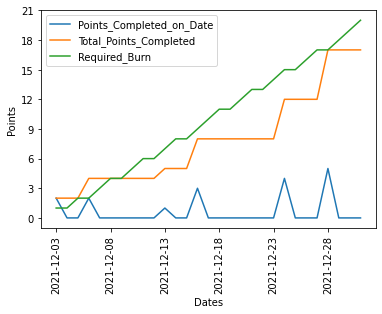

In [4]:
from matplotlib.ticker import MaxNLocator

fig = points_df.plot()
fig.yaxis.set_major_locator(MaxNLocator(integer=True)) # to force y axis to use integer

plt.xticks(rotation=90)
fig.set_xlabel('Dates')
fig.set_ylabel('Points')
fig

In [5]:
latest_issue = repo.get_issue(406)

import io
import base64
s = io.BytesIO()
plt = fig.get_figure()
plt.savefig(s, format='png', bbox_inches="tight")
s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
pic_hash = s


text = f"![IMAGE NOT FOUND](data:image/png;base64,{pic_hash})"
latest_issue.create_comment(body=text)

IssueComment(user=NamedUser(login="nischalstha9"), id=1003249563)